# [Demo] Derivation of echoed cross resonance with a rotary tone

IBM's standard CNOT implementation as of early 2022 is based on echoed cross resonance sequence with a rotary tone on the target qubit. This notebook tries to motivate this sequence from bottom-up.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import qudit_sim

qudit_sim.config.jax_devices = [0, 1]

try:
    os.mkdir('rotary_echo_cr')
except FileExistsError:
    pass

## System Hamiltonian

We will run the simulations in the qutrit space but extract qubit operators from the results.

In [2]:
hgen = qudit_sim.HamiltonianGenerator(3)
hgen.add_qudit(qubit_frequency=3.e+10, anharmonicity=-2.e+9, drive_amplitude=1.5e+9, qudit_id='q0')
hgen.add_qudit(qubit_frequency=3.3e+10, anharmonicity=-1.9e+9, drive_amplitude=1.7e+9, qudit_id='q1')
hgen.add_coupling('q0', 'q1', 1.e+7)
# Give a frame phase offset to q1 with respect to q0
# Inter-qubit phase offsets appear in real physical systems due to the (uncontrollable) phase shifts in microwave signals
# crossing two different temperature regimes (room temperature -> cryogenic)
hgen.frame('q1').phase[:] = 0.23

## Effective Hamiltonian of a cross resonance drive

We first check what terms are present in a vanilla cross resonance effective Hamiltonian.

In [3]:
test_amplitude = 0.2
num_cycles = 400

hgen.clear_drive()
hgen.add_drive('q0', frequency=hgen.frame('q1').frequency[0], amplitude=test_amplitude)
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, num_cycles), rwa=False)
components = qudit_sim.find_heff(sim_result, save_result_to='rotary_echo_cr/cr_heff')

max_frequency = hgen.max_frequency

Make sure all fits are reasonable:

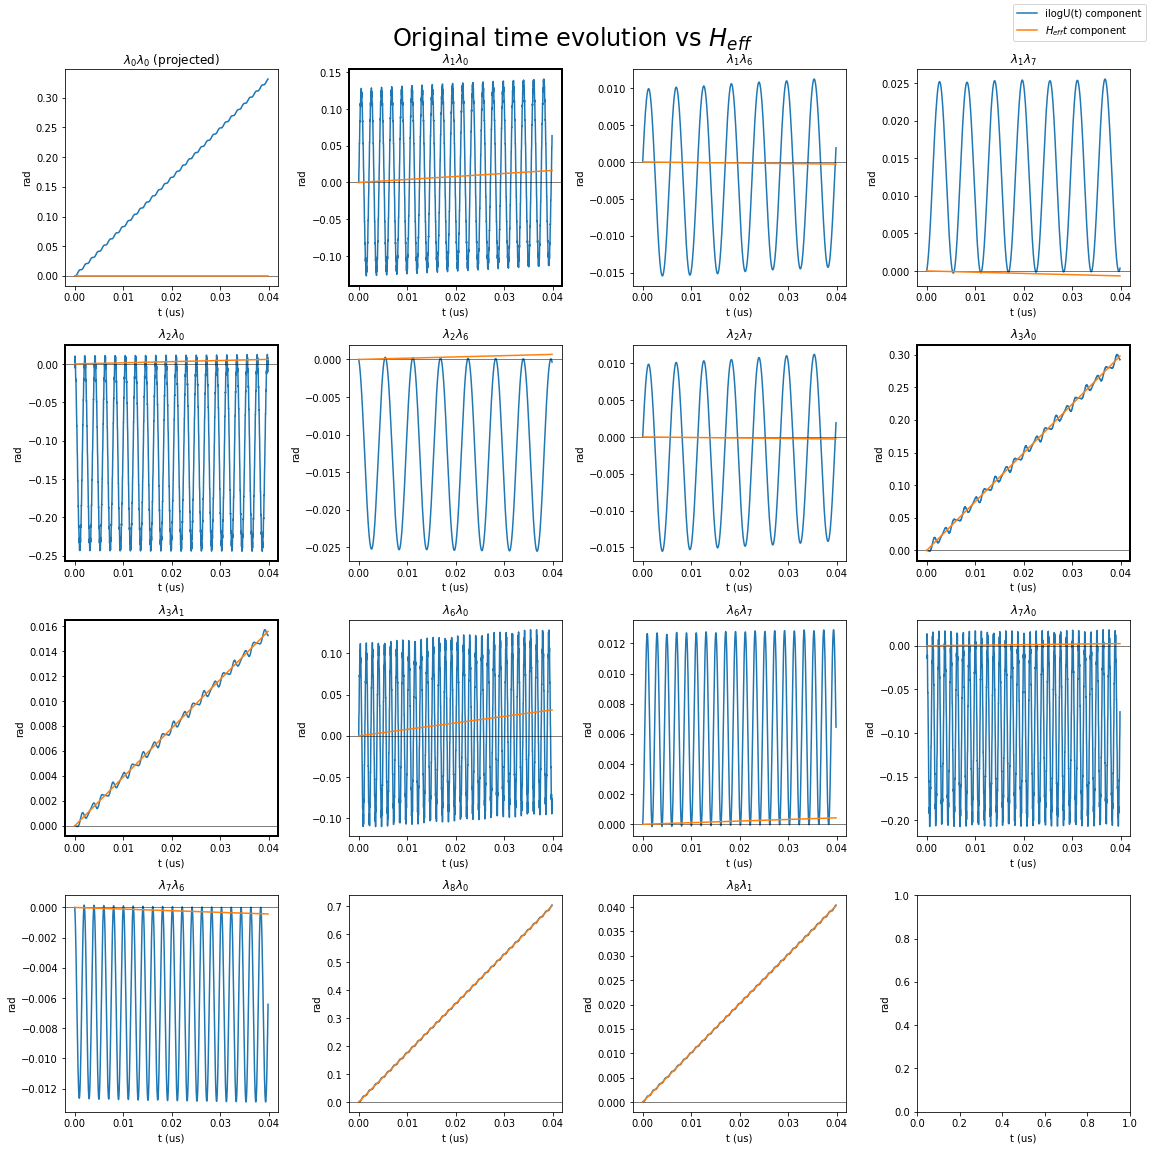

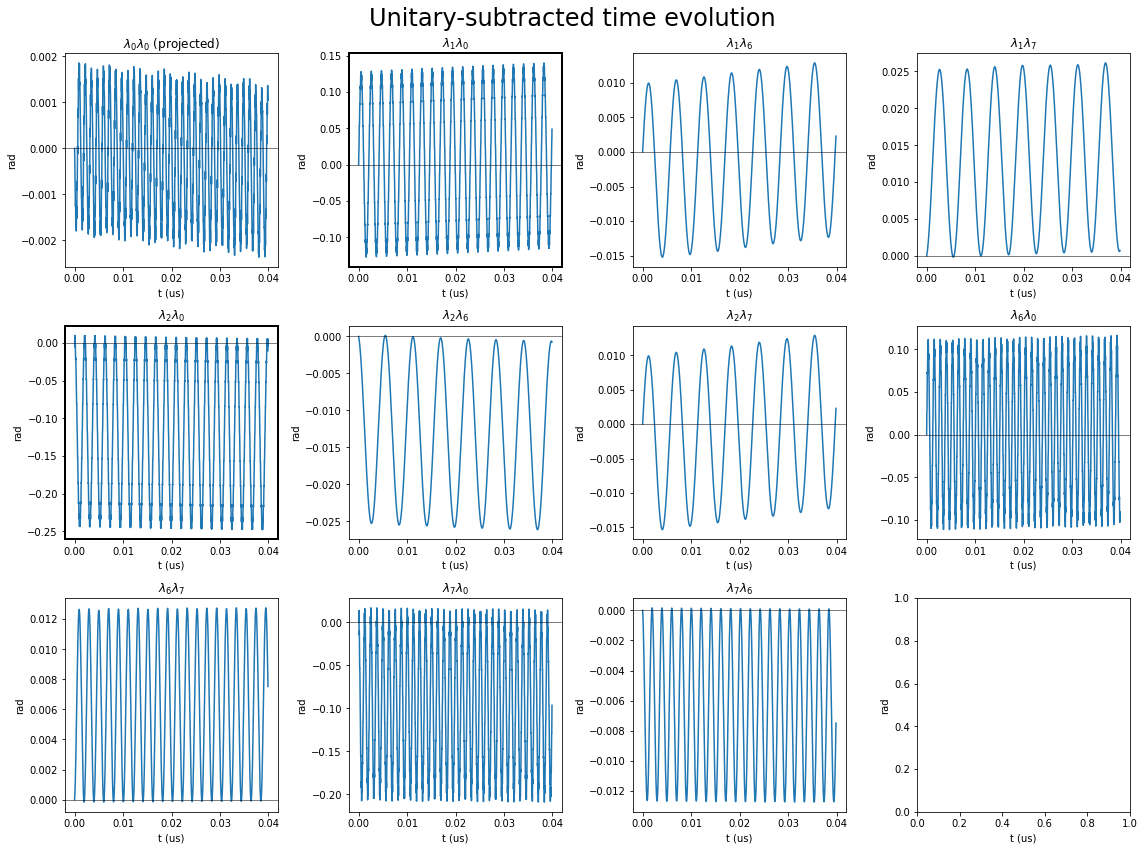

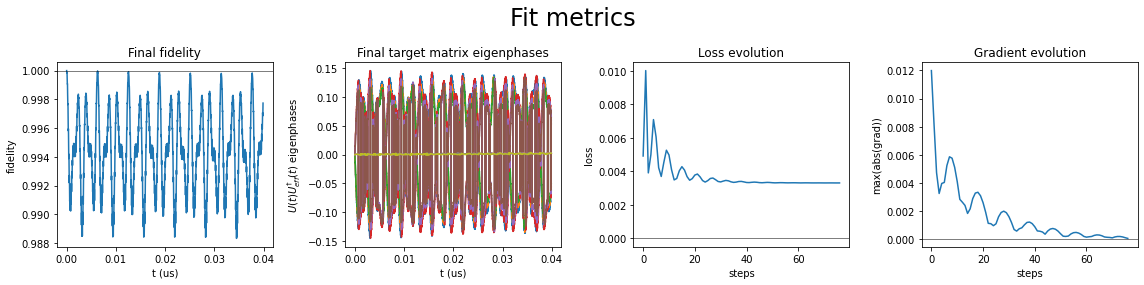

In [4]:
qudit_sim.heff.inspect_fidelity_maximization('rotary_echo_cr/cr_heff.h5');

No long-time linear trends are observed in the second set of plots (unitary-subtracted time evolution), so we move ahead.

In [5]:
qudit_sim.print_components(components)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{MHz}} = 1.317\frac{II}{2} + 0.093\frac{IX}{2} + 0.022\frac{IY}{2} + 0.011\frac{IZ}{2} + 0.053\frac{XI}{2} + 0.008\frac{XX}{2} + 0.001\frac{XY}{2} + 0.020\frac{YI}{2} + 0.002\frac{YX}{2} + 0.002\frac{YY}{2} + 0.972\frac{ZI}{2} + 0.062\frac{ZX}{2} + 0.015\frac{ZY}{2} - 0.011\frac{ZZ}{2} \end{split}")

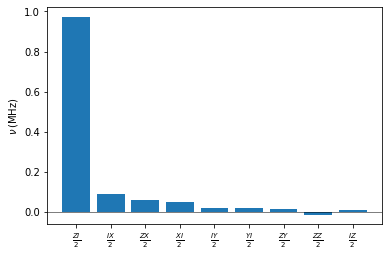

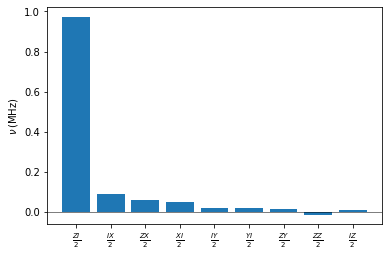

In [6]:
qudit_sim.plot_components(components)

The relevant terms appear to be ZI, IX, ZX, and XI. IY, YI, and ZY are also present due to the relative phase offsets.

## Amplitude scan of cross resonance

We would like to adjust the phase of the drive to eliminate the IY term later, but that generates a YI term, which won't be cancelled in the echo-CR sequence. So we try to find the sweet-spot amplitude that maximizes ZX with respect to XI.

In [7]:
hgen.clear_drive()

amplitudes = np.linspace(-0.5, 0.5, 20)

hgens = hgen.make_scan('amplitude', amplitudes, qudit_id='q0', frequency=hgen.frame('q1').frequency[0])

sim_results = qudit_sim.pulse_sim(hgens, tlist=(10, num_cycles), rwa=False)
components_list = qudit_sim.find_heff(sim_results, save_result_to='rotary_echo_cr/cr_amplitude_scan')

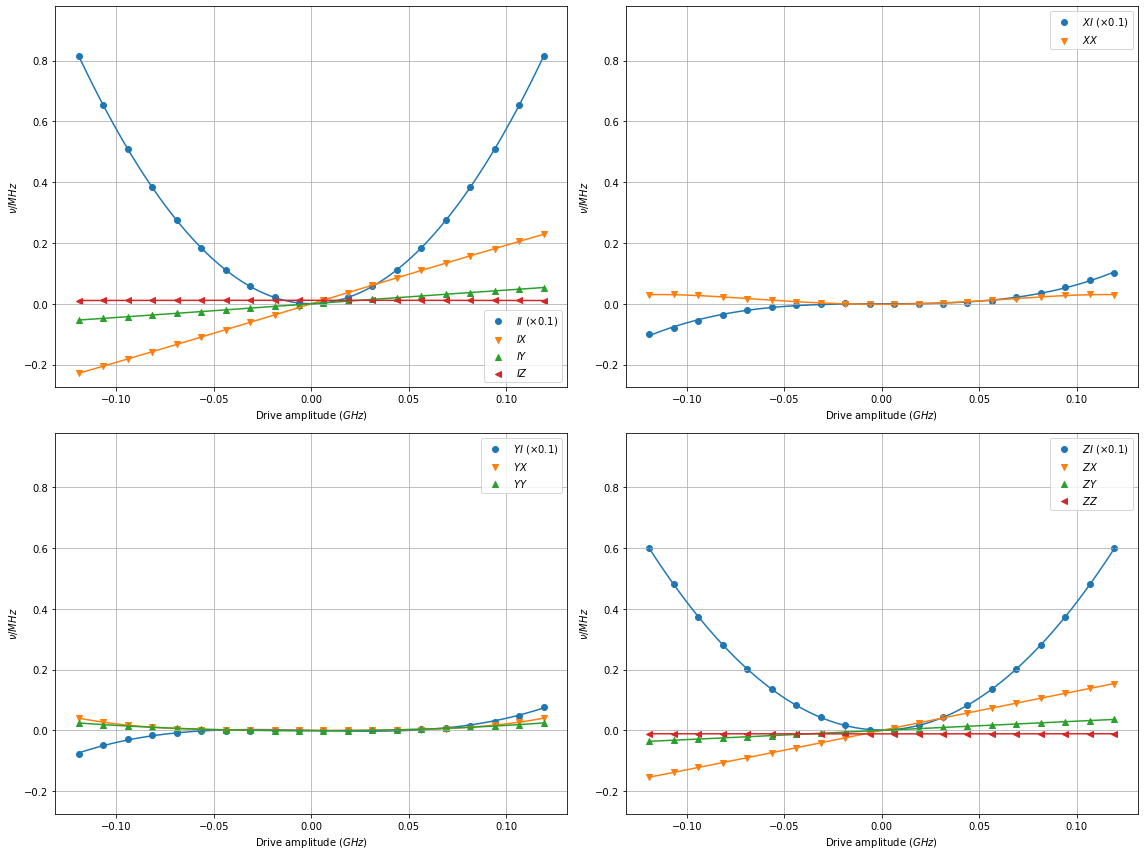

In [8]:
amp_base = hgen.qudit_params('q0').drive_amplitude
physical_amps = amp_base * amplitudes
fig, coefficients = qudit_sim.heff.plot_amplitude_scan(physical_amps, components_list)

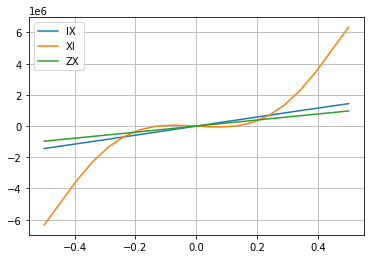

In [9]:
components = np.array(components_list)
plt.plot(amplitudes, components[:, 0, 1], label='IX')
plt.plot(amplitudes, components[:, 1, 0], label='XI')
plt.plot(amplitudes, components[:, 3, 1], label='ZX')
plt.grid()
plt.legend();

The `coefficients` array returned by `plot_amplitude_scan` contain the coefficients from the polynomial fits to the amplitude dependence.

In [10]:
# ZX(A) - XI(A) = (coefficients[3, 1, 3] - coefficients[1, 0, 3]) * A^3 + (coefficients[3, 1, 1] - coefficients[1, 0, 1]) * A
# -> d(ZX-XI)/dA = 0 => A_best = sqrt(-(coefficients[3, 1, 1] - coefficients[1, 0, 1]) / (coefficients[3, 1, 3] - coefficients[1, 0, 3]) / 3)
best_amplitude = np.sqrt((coefficients[1, 0, 1] - coefficients[3, 1, 1]) / (coefficients[3, 1, 3] - coefficients[1, 0, 3]) / 3.) / amp_base
print(best_amplitude)

0.10118787940062222


In [11]:
hgen.clear_drive()
hgen.add_drive('q0', frequency=hgen.frame('q1').frequency[0], amplitude=best_amplitude)
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, num_cycles), rwa=False)
components = qudit_sim.find_heff(sim_result)

In [12]:
qudit_sim.print_components(components)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{MHz}} = 0.340\frac{II}{2} + 0.047\frac{IX}{2} + 0.011\frac{IY}{2} + 0.011\frac{IZ}{2} - 0.007\frac{XI}{2} + 0.001\frac{XX}{2} + 0.004\frac{YI}{2} + 0.258\frac{ZI}{2} + 0.031\frac{ZX}{2} + 0.007\frac{ZY}{2} - 0.011\frac{ZZ}{2} \end{split}")

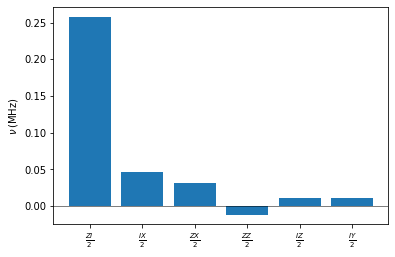

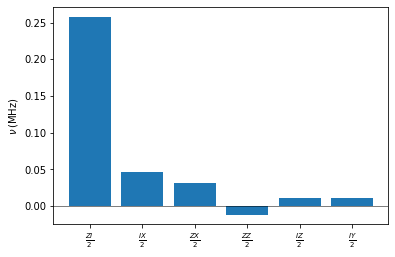

In [13]:
qudit_sim.plot_components(components)

## Fixing the cross resonance tone phase

Cross resonance tone accounting for the qudit phase difference:

In [14]:
# Of course we know that the phase offset is 0.23, but we'll determine it from the observed components values for illustration purpose
qudit_phase_offset = np.arctan2(components[0, 2], components[0, 1])
print(qudit_phase_offset)
best_amplitude *= np.exp(-1.j * qudit_phase_offset)

0.2300063457436085


In [15]:
hgen.clear_drive()
hgen.add_drive('q0', frequency=hgen.frame('q1').frequency[0], amplitude=best_amplitude)
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, num_cycles))
components = qudit_sim.find_heff(sim_result)

In [16]:
qudit_sim.print_components(components)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{MHz}} = 0.370\frac{II}{2} + 0.048\frac{IX}{2} + 0.011\frac{IZ}{2} + 0.013\frac{XI}{2} + 0.002\frac{XX}{2} + 0.001\frac{YI}{2} + 0.256\frac{ZI}{2} + 0.032\frac{ZX}{2} - 0.011\frac{ZZ}{2} \end{split}")

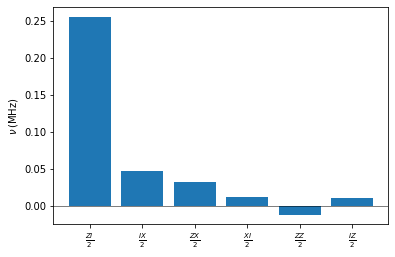

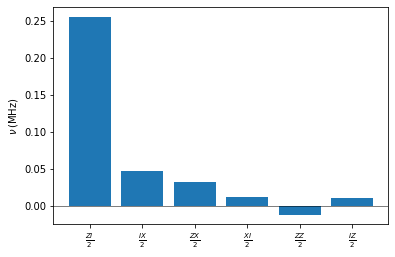

In [17]:
qudit_sim.plot_components(components)

## Finding the pulse for $R_{zx}(\pi/4)$

In [ ]:
widths = np.linspace(0., 3., 20)
sigma = 0.1

pulses = list()
tlists = list()
for width in widths:
    duration = width + 4 * sigma
    pulses.append(qudit_sim.GaussianSquare(duration=duration, amp=best_amplitude, sigma=sigma, width=width))
    
    # max_frequency is actually angular frequency
    cycle = 1. / max_frequency * 2. * np.pi
    num_tpoints = int(duration / cycle) * 10
    tlists.append(np.linspace(0., duration, num_tpoints))
    
hgen.clear_drive()

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=hgen.frame('q1').frequency[0])

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlists, rwa=False)
components_list = np.array(list(qudit_sim.gate_components(res) for res in sim_results))